## Characterization of haplotype-defining SNPs

Imports.

In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt # make simple visualizations
import pandas as pd # data management

import io_helpers # file I/O


This I/O helper file uses:
Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)],
Matplotlib version 3.7.1,
pandas version 1.5.3



Constants.

In [2]:
sample_info = io_helpers.load_sample_info_and_haplogroups(add_female_to_y=True)
seq_methods = ['lcWGS', 'ddGBS']

transitions = {'A': 'G', 'G': 'A', 'C': 'T', 'T': 'C'}
snp_locations = defaultdict(
    lambda: 'noncoding', synonymous_variant='coding', missense_variant='coding')
snp_effects = defaultdict(
    lambda: pd.NA, synonymous_variant='synonymous', missense_variant='missense')

y_depth = io_helpers.read_csv('data', 'depth', 'Y_depth.csv', index_col=0)
mt_depth = io_helpers.read_csv('data', 'depth', 'MT_depth.csv', index_col=0)

Helper functions.

In [3]:
def plot_coverage(depth: pd.Series, chrom: str, ax: plt.Axes, 
                  axis_label_fontsize: int, show_y_label: bool) -> None:
    """Plot coverage across a given region.
    
    Parameters
    ----------
    depth: pd.Series
        Read depth, labeled by 1-indexed position.
    chrom: str
        Chromosome this depth is over.
    ax: plt.Axes
        Axes to plot on.
    axis_label_fontsize: int
        Fontsize for the X/Y axis labels.
    show_y_label: bool
        Whether to label the Y axis with "Read depth".
    """

    ax.scatter(depth.index, depth, s=1, rasterized=True)
    ax.set_xticks([])
    
    ax.set_xlabel(f'Position along chr{chrom}', fontsize=axis_label_fontsize)
    if show_y_label: ax.set_ylabel('Read depth', fontsize=axis_label_fontsize)

def extract_snp_annotations(chrom: str) -> pd.DataFrame:
    """Process annotated VCF file into SNP effect data frame."""

    snps = io_helpers.read_csv('results', 'groups', f'{chrom}_SNPs.ann.vcf', 
                               skiprows=7, sep='\t')
    # snpeff outputs 'ANN=<alt>|<annotation>|<etc.>'
    snps['snpeff_ann'] = snps['INFO'].str.split('|', expand=True).iloc[:, 1]

    snps['base_change'] = snps[['REF', 'ALT']].apply(base_change_type, axis=1)
    snps['snp_location'] = snps['snpeff_ann'].map(snp_locations)
    snps['amino_change'] = snps['snpeff_ann'].map(snp_effects)
    return snps[['POS', 'base_change', 'snp_location', 'amino_change']]

def base_change_type(bases: list[str]) -> str:
    """Determine what kind of nucleotide change occurred."""
    return 'transition' if bases[0] == transitions[bases[1]] else 'transversion'

def string_histogram(vals: pd.Series, title: str, ax: plt.Axes) -> None:
    """Make frequency histogram for a set of strings.
    
    Parameters
    ----------
    vals: pd.Series
        Strings to make a frequency histogram for.
    title: str
        Title for plot
    ax: plt.Axes
        Axes to plot the histogram on.
    """

    counts = vals.value_counts(sort=False).sort_index()
    counts.plot(kind='bar', ax=ax, rot=0)
    
    ax.bar_label(ax.containers[0], labels=counts)
    ax.set_title(title)
    # make space for the bar labels
    ax.set_ylim(top=ax.get_ylim()[1] * 1.1)

Load in the annotated variants.

In [4]:
y_snps = extract_snp_annotations('Y')
mt_snps = extract_snp_annotations('MT')

Plot information about variants. This is *Figure S6*.

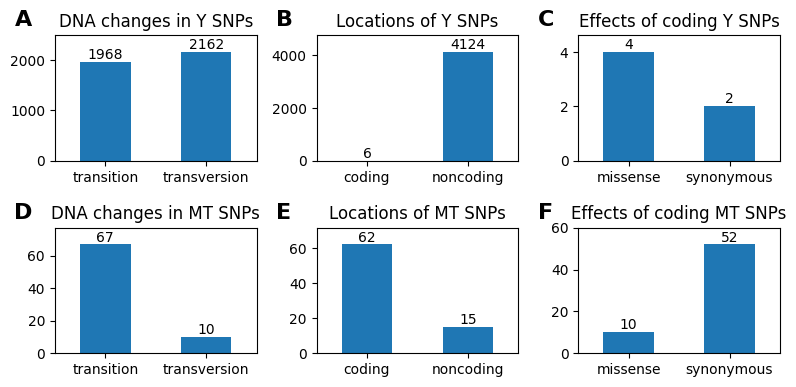

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=3)

chroms = ['Y', 'MT']
pretty_names = [('base_change', 'DNA changes in'), 
                ('snp_location', 'Locations of'), 
                ('amino_change', 'Effects of coding')]
tags = ['A', 'B', 'C', 'D', 'E', 'F']

for row in range(2):
    cur_chrom = chroms[row]
    snps = y_snps if cur_chrom == 'Y' else mt_snps

    for col in range(3):
        cur_col = pretty_names[col][0]
        title = f'{pretty_names[col][1]} {cur_chrom} SNPs'
        string_histogram(snps[cur_col], title, axs[row, col])

        tag = tags[row*3 + col]
        io_helpers.write_panel_tag(tag, -0.2, 1.2, ax=axs[row, col])

fig.set_size_inches(8, 4)
fig.tight_layout()

io_helpers.save_plot('SNP_effects', extension='png')

Plot read depth along Y and point out where variants are. This is *Figure S4*.

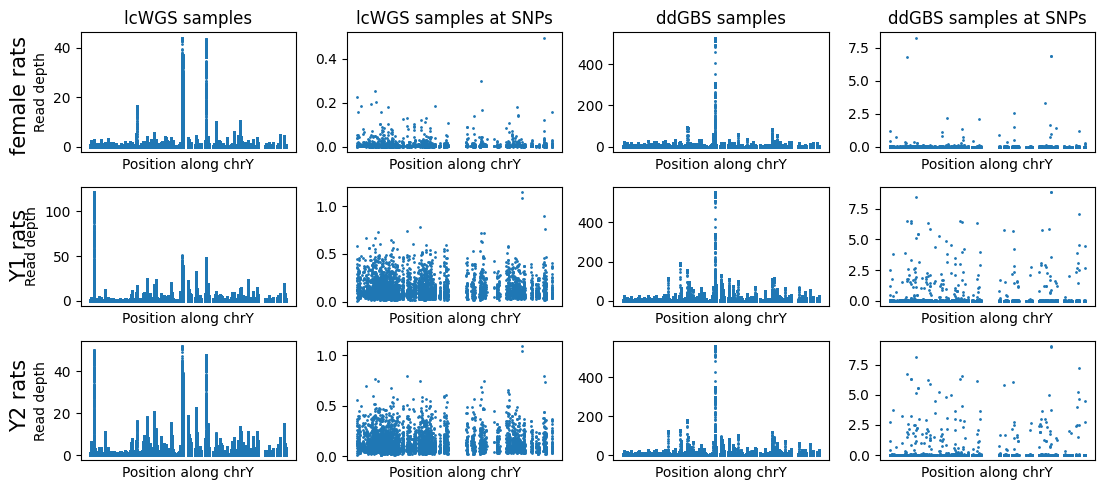

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=4, sharex=True)

groups = ['female', 'Y1', 'Y2']
snps_to_use = y_depth.index.intersection(y_snps['POS'])

for row in range(3):
    for method_i in range(len(seq_methods)):
        method = seq_methods[method_i]
        is_first_col = method_i==0

        group = f'{groups[row]}_{method}'
        rfids = sample_info.loc[(sample_info['Y_group'] == groups[row])
                                & (sample_info['seq_method'] == method)].index

        plot_coverage(y_depth[group] / len(rfids), 'Y', axs[row, method_i*2], 
                      axis_label_fontsize=10, show_y_label=is_first_col)
        plot_coverage(y_depth.loc[snps_to_use, group] / len(rfids), 'Y', 
                      axs[row, method_i*2 + 1], axis_label_fontsize=10,
                      show_y_label=False)

axs[0, 0].set_title('lcWGS samples')
axs[0, 1].set_title('lcWGS samples at SNPs')
axs[0, 2].set_title('ddGBS samples')
axs[0, 3].set_title('ddGBS samples at SNPs')

fig.text(0, 4/5, 'female rats', fontsize=15, va='center', rotation='vertical')
fig.text(0, 1/2, 'Y1 rats', fontsize=15, va='center', rotation='vertical')
fig.text(0, 1/5, 'Y2 rats', fontsize=15, va='center', rotation='vertical')

fig.set_size_inches(11, 5)
fig.tight_layout()
io_helpers.save_plot('Y_depth', extension='png', figure=fig)

Plot read depth along MT and point out where variants are. This is *Figure S10*.

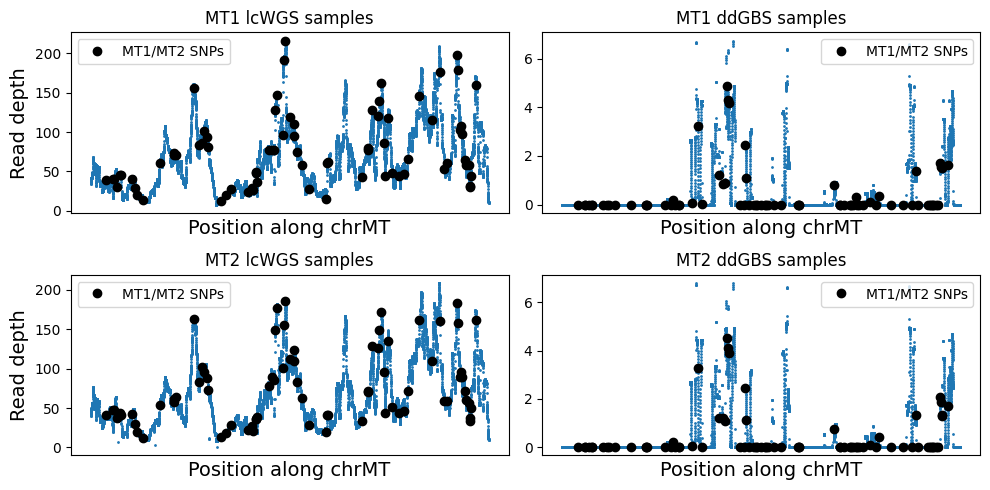

In [7]:
fig, axs = plt.subplots(2, 2)

for row in range(2):
    haplotype = f'MT{row+1}'
    for col in range(2):
        method = seq_methods[col]
        is_first_col = col==0

        rfids = sample_info.loc[(sample_info['MT_group'] == haplotype)
                                & (sample_info['seq_method'] == method)].index
        group = f'{haplotype} {method}'

        plot_coverage(mt_depth[rfids].mean(axis=1), 'MT', axs[row, col],
                      axis_label_fontsize=14, show_y_label=is_first_col)
        axs[row, col].plot(mt_snps['POS'],
                           mt_depth.loc[mt_snps['POS'], rfids].mean(axis=1),
                           linestyle='None', marker='o', color='black', 
                           label='MT1/MT2 SNPs')
        
        axs[row, col].set_title(f'{haplotype} {method} samples')
        axs[row, col].legend()

fig.set_size_inches(10, 5)
fig.tight_layout()

io_helpers.save_plot('MT_depth', extension='png', figure=fig)